# 04. PyTorch Custom Datasets Video Notebook 

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

On of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources**:
- Book version: https://www.learnpytorch.io/04_pytorch_custom_datasets
- Ground truth: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [175]:
import torch
from torch import nn

torch.__version__

'2.7.1+cu126'

In [176]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data
 
 Our dataset is a subset of Food101 dataset.

 Food 101 starts at 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small sclae and then increase the scale
when necessary.

The whole point is to speed up how fast you can experiment

In [177]:
import requests
import zipfile
from pathlib import Path

DATA_PATH = Path("data/")
IMAGE_PATH = DATA_PATH / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...

if IMAGE_PATH.is_dir():
    print(f"{IMAGE_PATH} directory already exists... Skipping download")
else:
    print(f"{IMAGE_PATH} does not exist, creating one...")
    IMAGE_PATH.mkdir(parents=True, exist_ok=True)


# Download pizza, steak, and sushi data
with open(DATA_PATH / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, and sushi data")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(DATA_PATH / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(IMAGE_PATH)

data/pizza_steak_sushi directory already exists... Skipping download
Unzipping pizza, steak, and sushi data...


## 2. Data preparation/exploration

In [178]:
import os 


def walk_through_dir(dir_path):
    """Walks through `dir_path` returning its contents."""
    for dir_paths, dir_names, file_names, in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories, and {len(file_names)} images in {dir_paths}")

In [179]:
walk_through_dir(IMAGE_PATH)

There are 2 directories, and 0 images in data/pizza_steak_sushi
There are 3 directories, and 0 images in data/pizza_steak_sushi/test
There are 0 directories, and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories, and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories, and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories, and 0 images in data/pizza_steak_sushi/train
There are 0 directories, and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories, and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories, and 72 images in data/pizza_steak_sushi/train/sushi


In [180]:
#Setup train and testing paths

train_dir = IMAGE_PATH / "train"
test_dir = IMAGE_PATH / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with iamges, let's open the image with Pythons' PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/steak/673127.jpg
Image class: steak
Image height: 512
Image width: 512


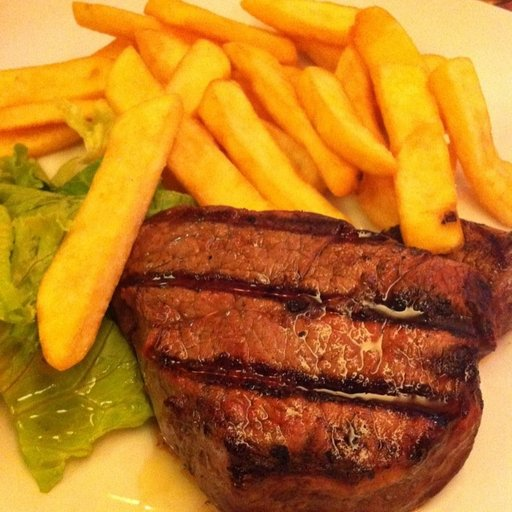

In [181]:
import random
from PIL import Image


# random.seed(42)

# 1. Get all the image paths
image_path_list = list(IMAGE_PATH.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

array([[[165,  98, 107],
        [163,  96, 105],
        [165,  98, 107],
        ...,
        [118,  83,  79],
        [162, 135, 128],
        [196, 173, 165]],

       [[163,  96, 105],
        [163,  96, 105],
        [165,  98, 107],
        ...,
        [142, 109, 104],
        [181, 156, 149],
        [197, 177, 168]],

       [[162,  97, 105],
        [163,  98, 106],
        [163,  98, 106],
        ...,
        [147, 118, 114],
        [193, 170, 164],
        [200, 181, 174]],

       ...,

       [[ 26,  10,  11],
        [ 27,  11,  12],
        [ 30,  11,  13],
        ...,
        [216, 211, 208],
        [216, 211, 208],
        [216, 211, 208]],

       [[ 29,  10,  12],
        [ 28,   9,  11],
        [ 27,   8,  10],
        ...,
        [216, 211, 208],
        [216, 211, 208],
        [216, 211, 208]],

       [[ 27,   8,  10],
        [ 24,   5,   7],
        [ 22,   3,   5],
        ...,
        [216, 211, 208],
        [216, 211, 208],
        [216, 211, 208]]

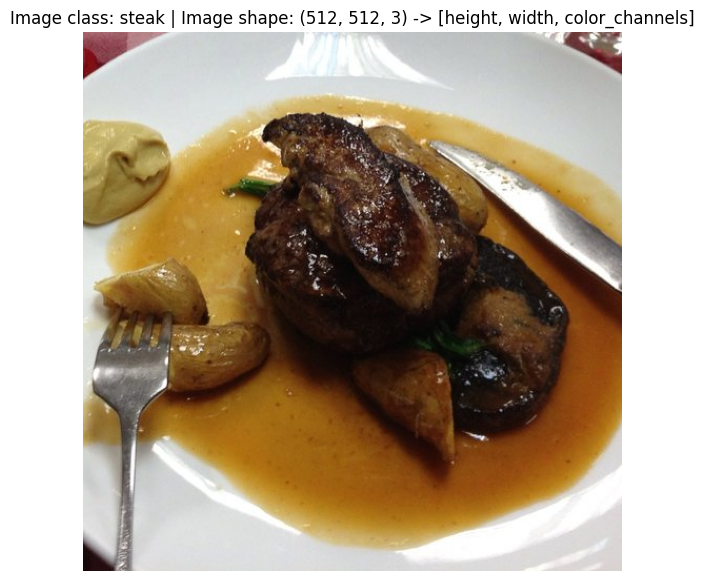

In [ ]:
# Plotting a random image with numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt


# Turn the img into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)
img_as_array

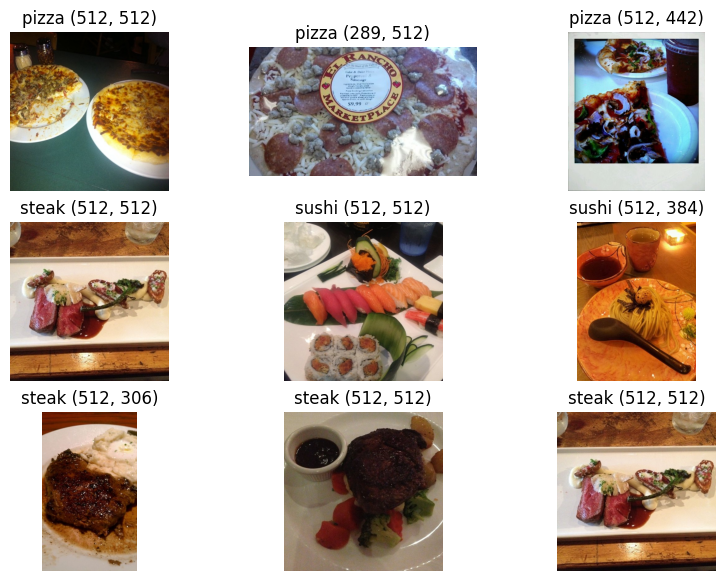

In [ ]:
# Plotting random images

fig = plt.figure(figsize=(10,7))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    random_img_path = random.choice(image_path_list)
    img_class = random_img_path.parent.stem
    fig.add_subplot(rows, cols, i)
    random_img = Image.open(random_img_path)
    plt.imshow(random_img)
    plt.title(f"{img_class} ({random_img.height}, {random_img.width})")
    plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`,
we'll call this `Datasets` and `DataLoaders`

In [201]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # Resize our images to 64x64
    transforms.RandomHorizontalFlip(p=0.5),  #Flip the images randomly on the horizontal
    transforms.ToTensor()  # Turn the images into torch.Tensor
])  

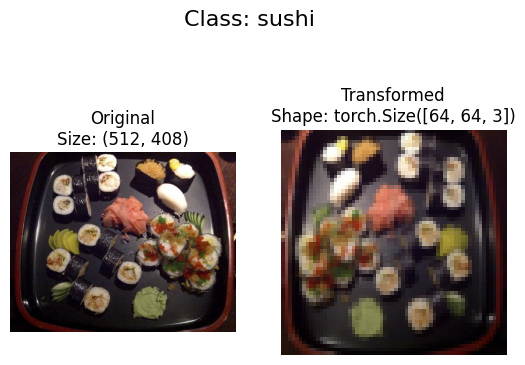

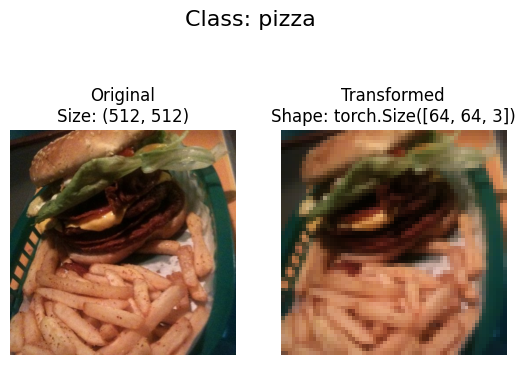

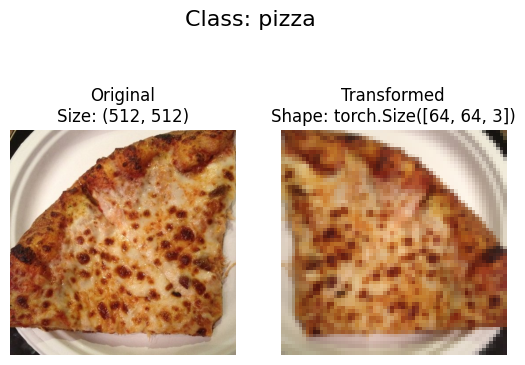

In [214]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms then plots the original vs transformed version 
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)  # Note: we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}") 
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)